# Basic Imports & Setup
- Mounting onto Google Drive
- Importing important libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display


import torch
from torch import nn
from torch.nn import functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

In [ ]:
%cd /content/drive/MyDrive/CS753_Project
%cd data

/content/drive/MyDrive/CS753_Project
/content/drive/MyDrive/CS753_Project/data


# Dataset Preparation - ICSI
The first dataset that we chose was the ICSI Meetings Dataset which has recordings of meetings from a central audio recorder as well as from multiple headsets, one per speaker. One such example was downloaded. The corresponding sph files are the headphone recordings.

Some characteristics about this dataset -
- Very noisy
- No explicit labels provided, need to use audio from individual headphone recordings to create labels
- Not so suitable for as this paper's application given PIT would be very slow for a lot of speakers (~12 in the example downloaded)

In [ ]:
!wget    -P Signals/Bdb001 https://groups.inf.ed.ac.uk/ami//ICSIsignals/NXT/Bdb001.interaction.wav
!wget    -P Signals/Bdb001 https://groups.inf.ed.ac.uk/ami//ICSIsignals/SPH/Bdb001/chan1.sph
!wget    -P Signals/Bdb001 https://groups.inf.ed.ac.uk/ami//ICSIsignals/SPH/Bdb001/chan2.sph
!wget    -P Signals/Bdb001 https://groups.inf.ed.ac.uk/ami//ICSIsignals/SPH/Bdb001/chan3.sph
!wget    -P Signals/Bdb001 https://groups.inf.ed.ac.uk/ami//ICSIsignals/SPH/Bdb001/chan4.sph
!wget    -P Signals/Bdb001 https://groups.inf.ed.ac.uk/ami//ICSIsignals/SPH/Bdb001/chan6.sph
!wget    -P Signals/Bdb001 https://groups.inf.ed.ac.uk/ami//ICSIsignals/SPH/Bdb001/chan7.sph
!wget    -P Signals/Bdb001 https://groups.inf.ed.ac.uk/ami//ICSIsignals/SPH/Bdb001/chan8.sph
!wget    -P Signals/Bdb001 https://groups.inf.ed.ac.uk/ami//ICSIsignals/SPH/Bdb001/chanB.sph
!wget    -P Signals/Bdb001 https://groups.inf.ed.ac.uk/ami//ICSIsignals/SPH/Bdb001/chanC.sph
!wget    -P Signals/Bdb001 https://groups.inf.ed.ac.uk/ami//ICSIsignals/SPH/Bdb001/chanD.sph
!wget    -P Signals/Bdb001 https://groups.inf.ed.ac.uk/ami//ICSIsignals/SPH/Bdb001/chanE.sph
!wget    -P Signals/Bdb001 https://groups.inf.ed.ac.uk/ami//ICSIsignals/SPH/Bdb001/chanF.sph

In [ ]:
files = os.listdir('Signals/Bdb001')
files = list(filter(lambda x: x[-3:] == "sph", files))
print(files)

['chanF.sph', 'chan6.sph', 'chan1.sph', 'chanB.sph', 'chan3.sph', 'chanC.sph', 'chan4.sph', 'chanD.sph', 'chanE.sph', 'chan8.sph', 'chan2.sph', 'chan7.sph']


Let's visualize individual recordings of the headphones and compare them to the main central recording which is very noisy. Notice the following points -
- There are a couple of primary speakers (~3), most others are silent almost all the time.
- Even with silence, the signal is not clean. This makes a threshold necessary to filter out audio.

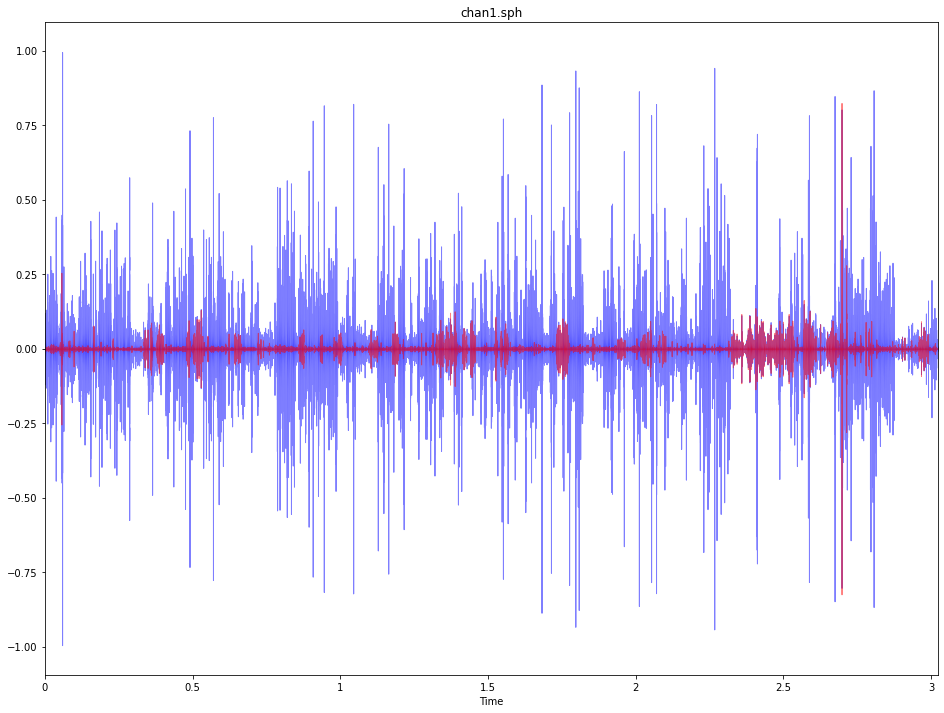

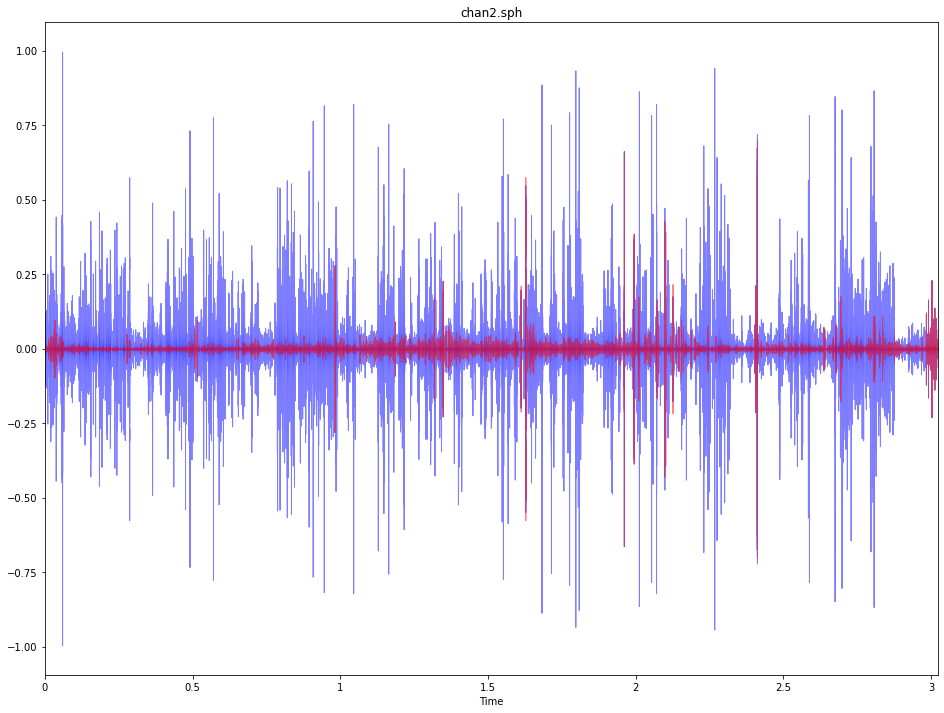

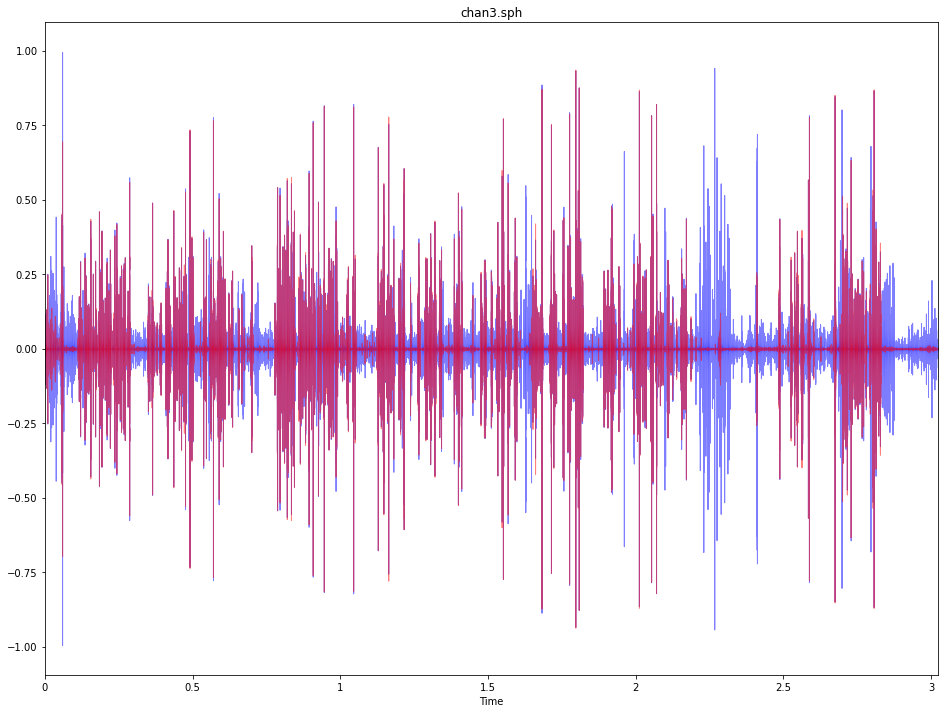

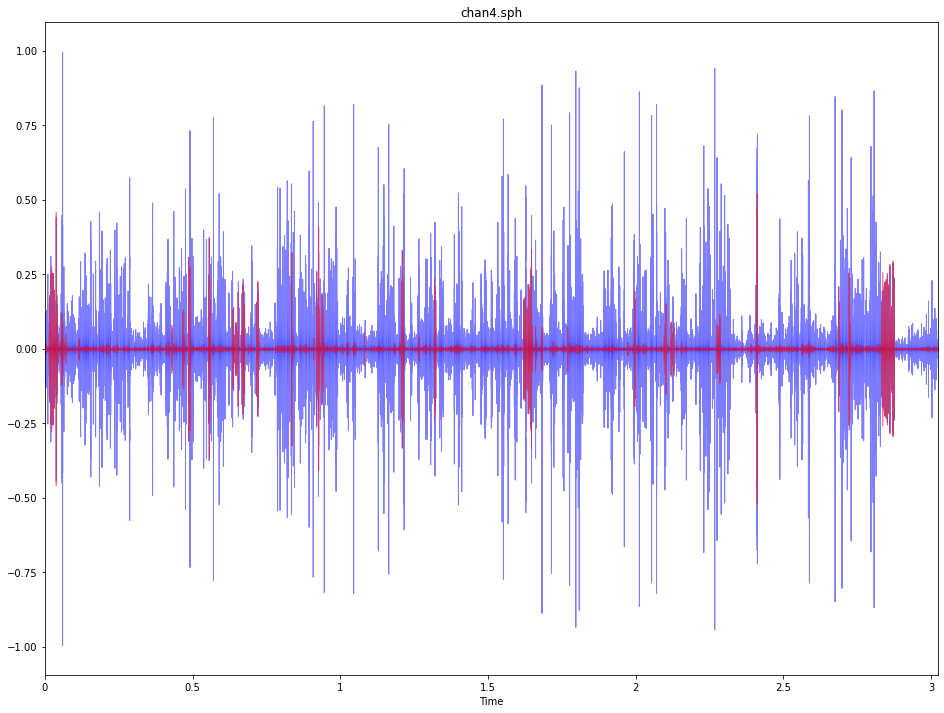

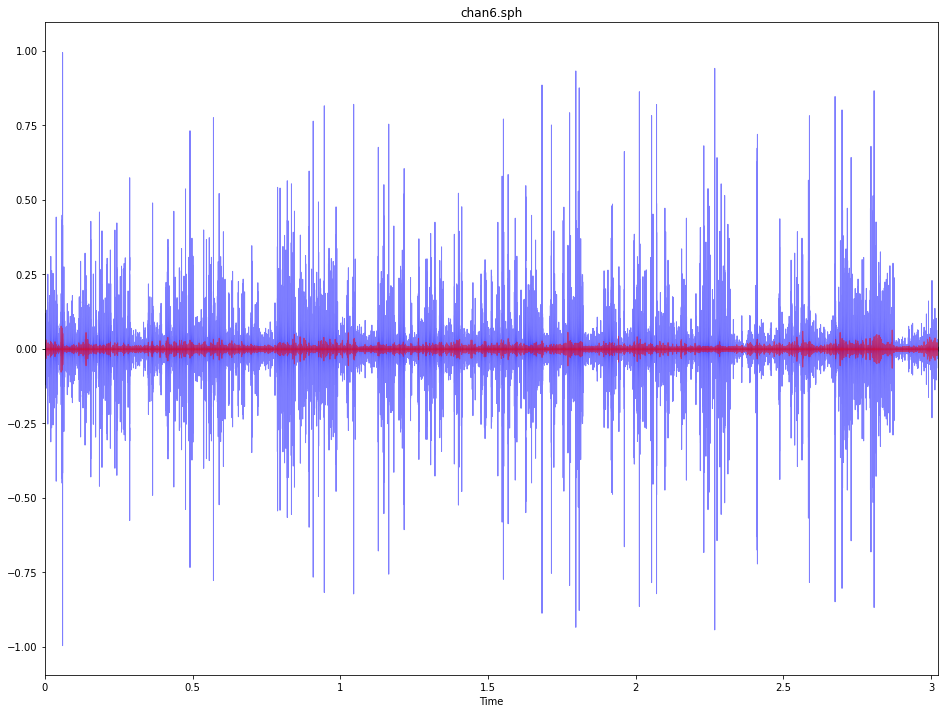

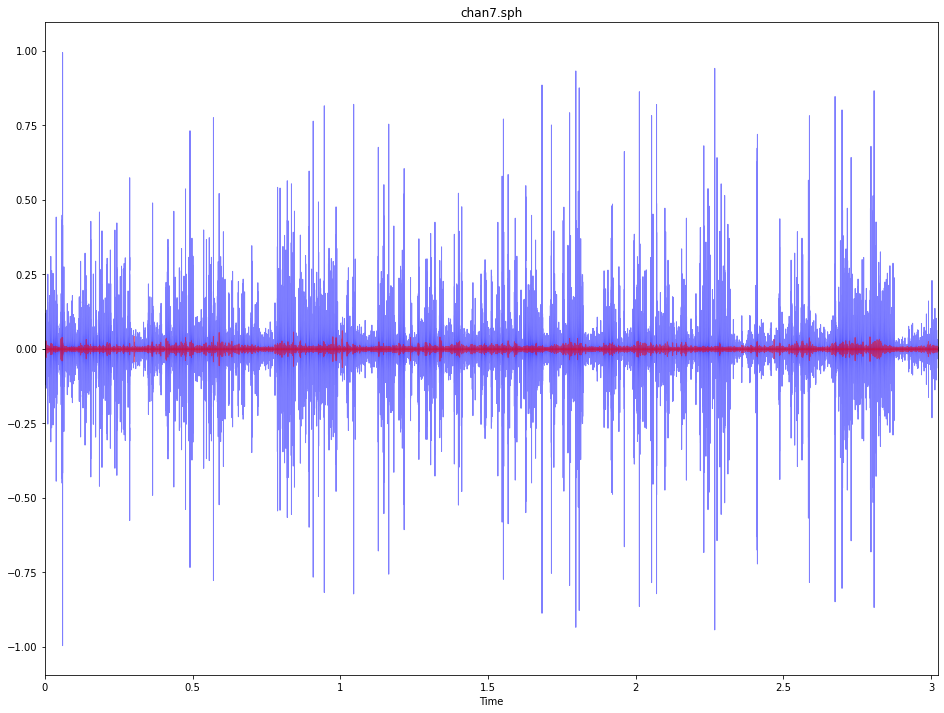

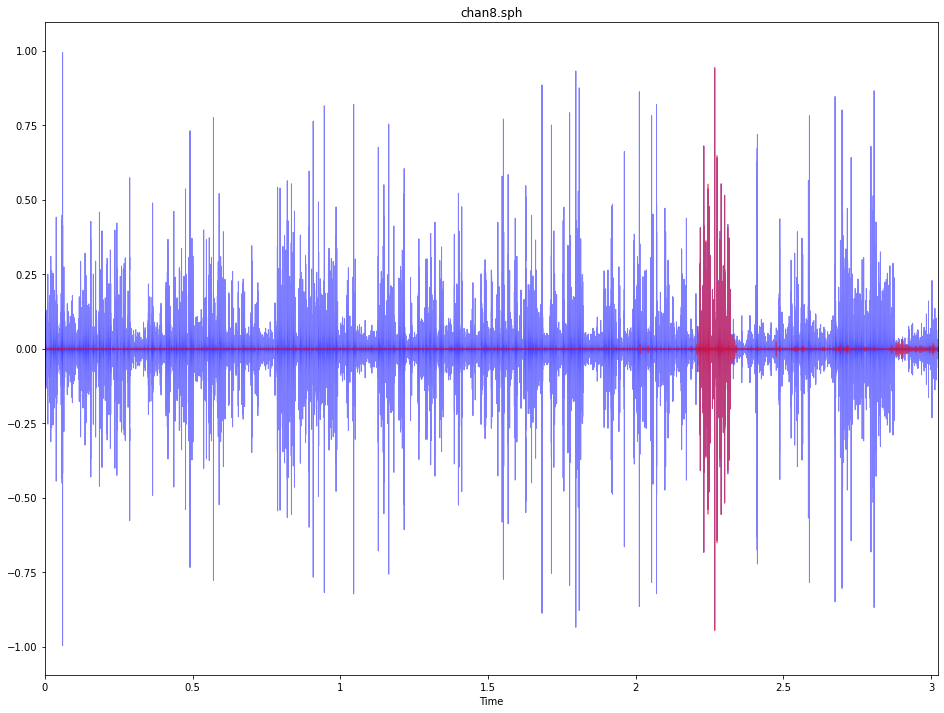

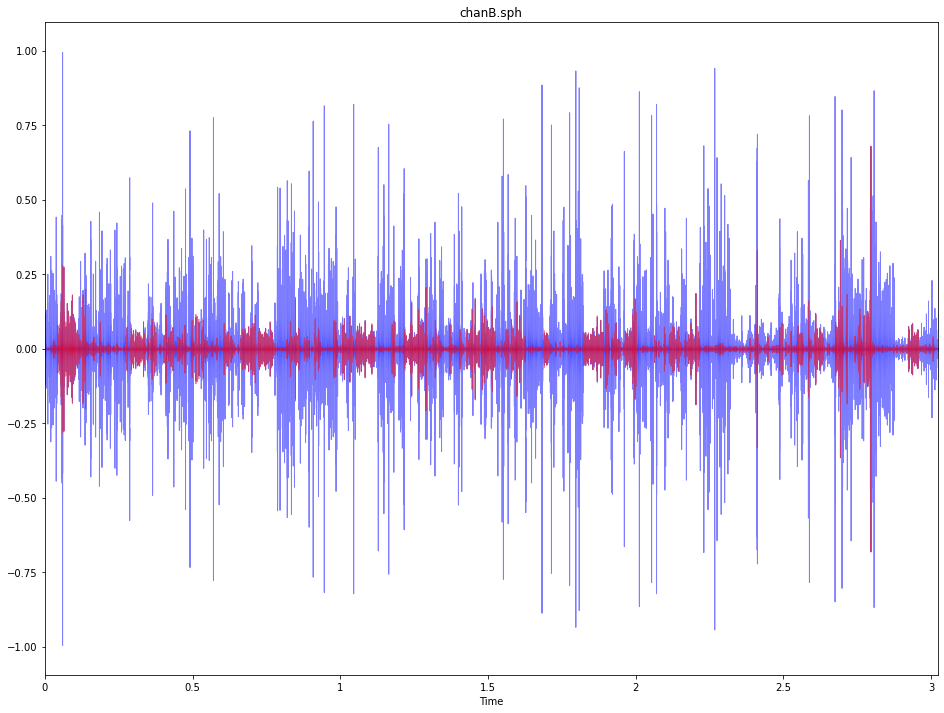

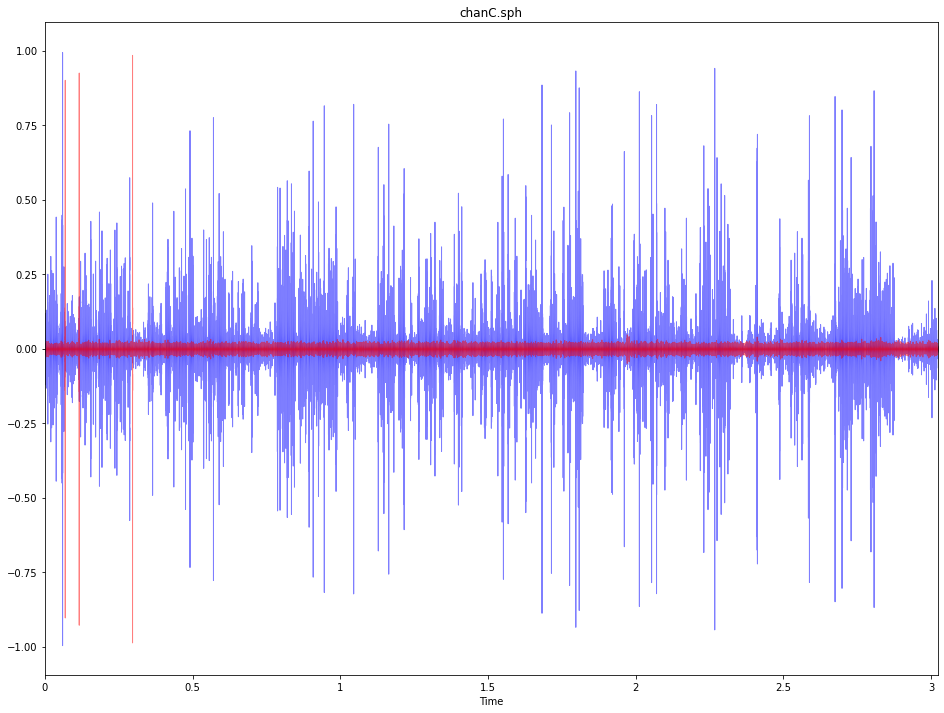

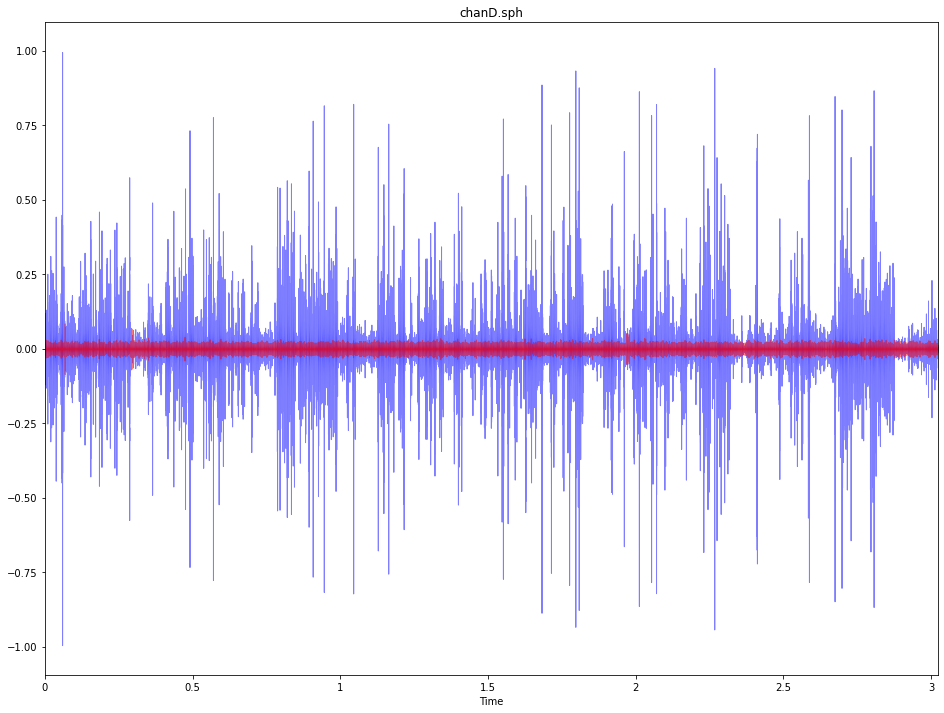

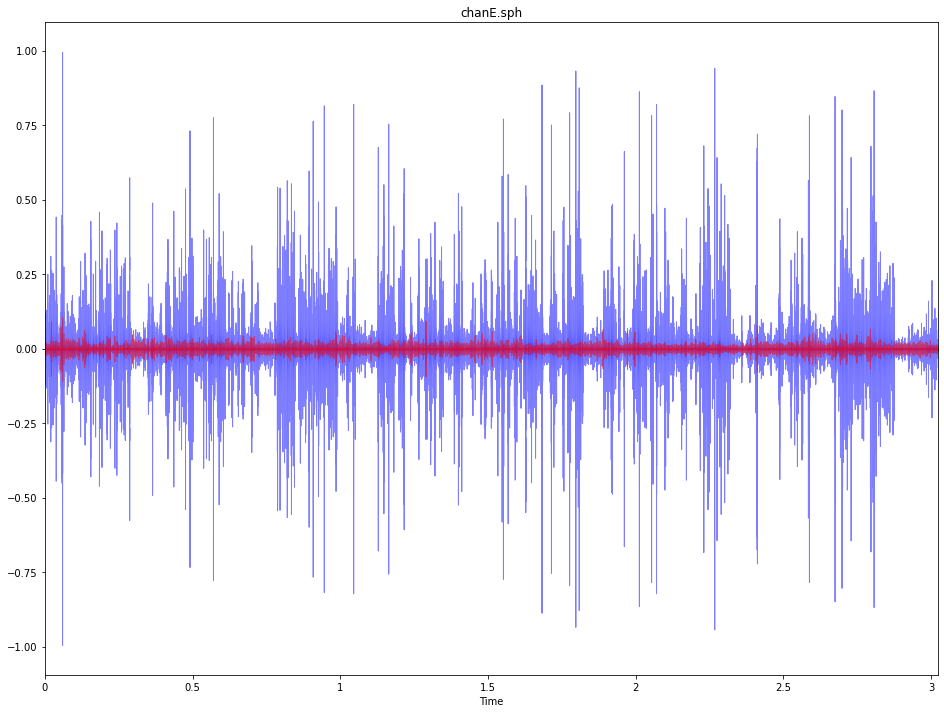

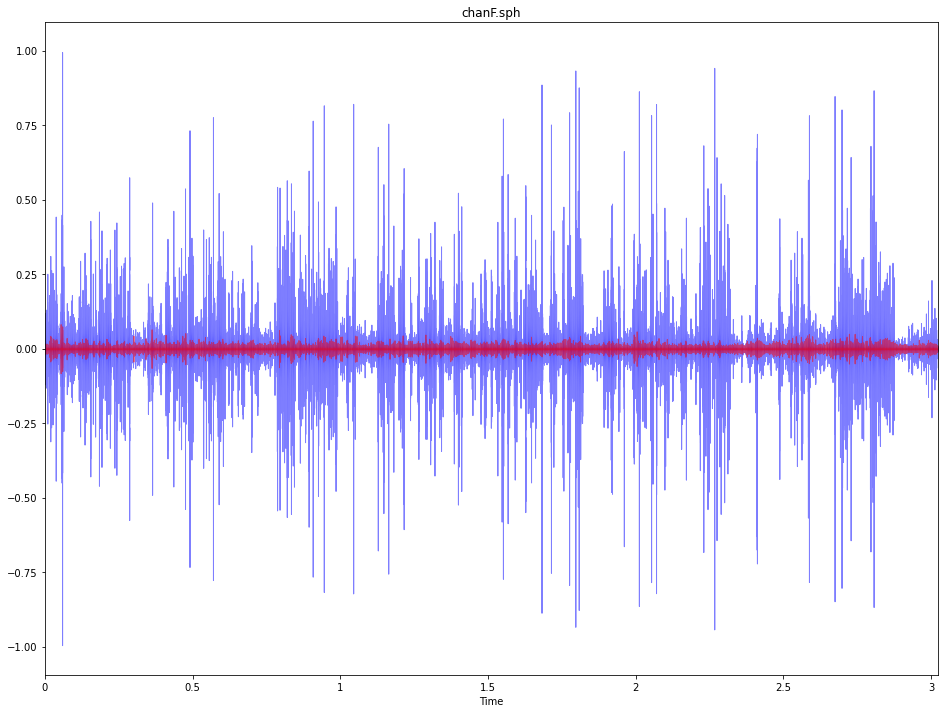

In [ ]:
import warnings
warnings.filterwarnings("ignore")

audio_main, sr_main = librosa.load('Signals/Bdb001/Bdb001.interaction.wav', sr=16000)
audios_speakers = []
for file in files:
    audio, sr = librosa.load('Signals/Bdb001/' + file, sr=16000)
    assert sr == 16000
    audios_speakers.append(audio)
    plt.figure(figsize=(16, 12))
    librosa.display.waveplot(audio_main[::1000], sr=sr, color='b', alpha=0.5)
    librosa.display.waveplot(audio[::1000], sr=sr, color='r', alpha=0.5)
    plt.title(file)
    plt.show()

Printing, with file name, fraction of the time when the signal is larger than it's mean. This isn't so believable as the values turn out to be pretty high for a lot of the speakers while that shouldn't be the case.

In [ ]:
print(files)
avg = list(map(lambda x: np.sum(np.abs(x)>np.mean(np.abs(x)))/len(x), audios_speakers))
print(avg)

['chan4.sph', 'chanF.sph', 'chanC.sph', 'chan3.sph', 'chan6.sph', 'chanB.sph', 'chanD.sph', 'chan2.sph', 'chan7.sph', 'chan1.sph', 'chanE.sph', 'chan8.sph', 'Bdb001.interaction.wav']
[0.044036711895950154, 0.22413007753969638, 0.3031019890891138, 0.057127967799450396, 0.16033492271179794, 0.05594933595549345, 0.3119511382769191, 0.0522395659603645, 0.1405040303633167, 0.052670746501580434, 0.21007774486289588, 0.014484836872786233, 0.002454738452435823]


Using a naive heuristic for noise, checking if amplitude at that point of time exceeds 0.05 or not.

In [ ]:
speaker_utterances = []
for audio in audios_speakers:
    speaker_utterances.append(np.abs(audio)>0.05)
    print(np.sum(speaker_utterances[-1])/len(speaker_utterances[-1]))

0.004428721356110785
0.004677051400162015
0.0721126911688401
0.010937007765882533
0.0001239892241265202
3.3339554510750726e-05
0.0035416451572766595
0.011424195449539633
0.0005331226405853731
5.0836615997162085e-05
0.0006377947779172028
0.0002944511399314876


In [ ]:
print(speaker_utterances[0].shape)

(48350976,)


In [ ]:
# Save data
import pickle
with open('main_audio.pkl', 'wb') as f:
    pickle.dump(audio_main, f)
with open('audio_diarize.pkl', 'wb') as f:
    pickle.dump(speaker_utterances, f)

### Label Preparation for frame sampling rate of 25 ms
- The sampling rate comes from the paper's recommendation.
- If the total number of observations in that 25 ms interval where the amplitude is larger than 0.05 exceeds 100 (out of 400, because sampling rate is taken to be 16k), it is considered to be that speaker's voice.

In [ ]:
import pickle

with open('mfcc_audio.pkl', 'rb') as f:
    mfcc = pickle.load(f)
with open('audio_diarize.pkl', 'rb') as f:
    label_data = pickle.load(f)

In [ ]:
label_data_frames = []
ind = 0
for speaker in label_data:
    speaker_arr = []
    for i in range(list(mfcc.size())[2]):
        speaker_arr.append(int(np.sum(speaker[400*i:min(400*i+400, label_data[0].shape[0])])>100))
    print(np.sum(speaker_arr)/len(speaker_arr))
    label_data_frames.append(np.array(speaker_arr))

0.0037806714207713563
0.006626515991330102
0.11380069160641308
0.018150531941296184
4.9636823905094395e-05
0.0
0.004649315839110508
0.01462631744403448
0.0005790962788927679
7.44552358576416e-05
0.0006121874948294975
0.00020682009960455998


In [ ]:
label_data_frames = np.array(label_data_frames)
print(label_data_frames.shape)

(12, 120878)


In [ ]:
with open('audio_diarize_subsampled.pkl', 'wb') as f:
    pickle.dump(label_data_frames, f)

# Feature Preparation - ICSI
- Melspectrogram and MFCC features were prepared for this dataset using the PyTorch implementation.

In [ ]:
path = "/content/drive/MyDrive/CS753_Project/data/Signals/Bdb001/Bdb001.interaction.wav"

def _get_sample(path, resample=None):
    effects = [["remix", "1"]]
    if resample:
        effects.extend(
            [
                ["lowpass", f"{resample // 2}"],
                ["rate", f"{resample}"],
            ]
        )
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(path, resample=None):
    return _get_sample(path, resample=resample)

waveform, sample_rate = get_speech_sample(path)

n_fft = 1024
win_length = None
hop_length = 400
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)
print(melspec.size())
# plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

torch.Size([1, 128, 120878])


In [ ]:
import pickle

with open('main_audio.pkl', 'rb') as f:
    audio = pickle.load(f)

(48350976,)


In [ ]:
print(audio.shape[0]/400)

120877.44


In [ ]:
waveform, sample_rate = get_speech_sample(path)

n_fft = 2048
win_length = None
hop_length = 400
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(waveform)
print(mfcc.size())

torch.Size([1, 256, 120878])


In [ ]:
import pickle
with open('mfcc_audio.pkl', 'wb') as f:
    pickle.dump(mfcc, f)
with open('melspec_audio.pkl', 'wb') as f:
    pickle.dump(melspec, f)

# Dataset Preparation - LibriSpeech (EMRAI)
- This is the second dataset we consider, a synthetic dataset prepared using LibriSpeech as a part of [this repository](https://github.com/EMRAI/emrai-synthetic-diarization-corpus).
- Notice the audio signal here, much more frequent audio than the previous case.
- The case taken into consideration here is that of 2 speakers.


In [ ]:
!wget https://raw.githubusercontent.com/EMRAI/emrai-synthetic-diarization-corpus/master/librispeech2/train_clean_100/ctms/1069-133699.8838-298546.ctm
!wget https://github.com/EMRAI/emrai-synthetic-diarization-corpus/raw/master/librispeech2/train_clean_100/wavs/1069-133699.8838-298546.wav

(12058602,)


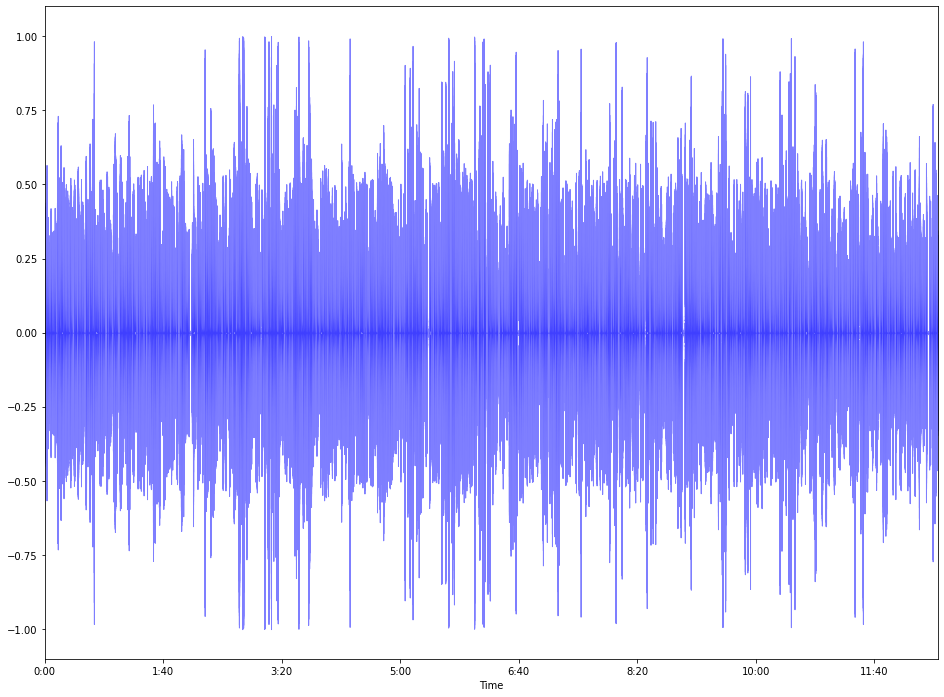

In [ ]:
audio, sr = librosa.load('1069-133699.8838-298546.wav', sr=16000)
print(audio.shape)
assert sr == 16000
plt.figure(figsize=(16, 12))
librosa.display.waveplot(audio, sr=sr, color='b', alpha=0.5)
plt.show()

# Feature Preparation - LibriSpeech (EMRAI)
- Melspectrogram and MFCC features were prepared for this dataset using the PyTorch implementation.
- Labels were already available in the `ctm` files in the repository. Time-level labels were converted to the frame-level labels through the obvious scaling method.

In [ ]:
path = "1069-133699.8838-298546.wav"

def _get_sample(path, resample=None):
    effects = [["remix", "1"]]
    if resample:
        effects.extend(
            [
                ["lowpass", f"{resample // 2}"],
                ["rate", f"{resample}"],
            ]
        )
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(path, resample=None):
    return _get_sample(path, resample=resample)

waveform, sample_rate = get_speech_sample(path)
print(sample_rate)
n_fft = 1024
win_length = None
hop_length = 400
n_mels = 32

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)
print(melspec.size())
# plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

16000
torch.Size([1, 32, 59630])


In [ ]:
print(waveform.size()[1]/400)

59629.56


In [ ]:
waveform, sample_rate = get_speech_sample(path)

n_fft = 2048
win_length = None
hop_length = 400
n_mels = 256
n_mfcc = 32

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(waveform)
print(mfcc.size())

torch.Size([1, 32, 59630])


In [ ]:
with open('/content/drive/MyDrive/CS753_Project/mfcc_emrai.pkl', 'wb') as f:
    pickle.dump(mfcc, f)
with open('/content/drive/MyDrive/CS753_Project/melspec_emrai.pkl', 'wb') as f:
    pickle.dump(melspec, f)
with open('/content/drive/MyDrive/CS753_Project/wave_emrai.pkl', 'wb') as f:
    pickle.dump(waveform, f)

### Label Preparation

In [ ]:
label_audio = torch.zeros(2, mfcc.size()[2])
labels = list(map(lambda x: list(map(lambda y: float(y), x.split()[1:-1])), open('1069-133699.8838-298546.ctm', 'r').read().strip().split('\n')))
print(len(labels))
print(labels[0])

15214
[1.0, 0.0, 0.51]


In [ ]:
duration = librosa.get_duration(waveform.numpy().reshape((-1,)), sr=16000)
frame_cnt = melspec.size()[2]

In [ ]:
for x in labels:
    index = 0
    if x[0] > 1.5:
        index = 1
    label_audio[index,int(x[1]*frame_cnt/duration):int((x[1]+x[2])*frame_cnt/duration)] = 1
print(torch.sum(label_audio))

tensor(61102.)


In [ ]:
with open('/content/drive/MyDrive/CS753_Project/label_emrai.pkl', 'wb') as f:
    pickle.dump(label_audio, f)

# Load Data, Dataset Class
- In this section, the datasets are loaded and the dataset class is defined for the small experiment (where we use small sequences as inputs)

### ICSI

In [ ]:
import gdown
url_1 = 'https://drive.google.com/uc?id=1-0R499jT1mkVsx3JnXhlvDKRTOUK2siu'
output = 'audio_diarize_subsampled.pkl'
gdown.download(url_1, output, quiet=False)
url_2 = 'https://drive.google.com/uc?id=1VydjFxiNERzebwvnBMmFLWY1HRIMxGJT'
output = 'mfcc_audio.pkl'
gdown.download(url_2, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-0R499jT1mkVsx3JnXhlvDKRTOUK2siu
To: /content/audio_diarize_subsampled.pkl
100%|██████████| 11.6M/11.6M [00:00<00:00, 234MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VydjFxiNERzebwvnBMmFLWY1HRIMxGJT
To: /content/mfcc_audio.pkl
100%|██████████| 124M/124M [00:01<00:00, 109MB/s]


'mfcc_audio.pkl'

In [ ]:
import pickle

with open('mfcc_audio.pkl', 'rb') as f:
    mfcc = pickle.load(f)
with open('audio_diarize_subsampled.pkl', 'rb') as f:
    label_data = pickle.load(f)
mfcc = mfcc[0]
print(mfcc.size(), label_data.shape)

torch.Size([256, 120878]) (12, 120878)


In [ ]:
for idx, x in enumerate(label_data):
    print(idx, np.sum(x))

0 457
1 801
2 13756
3 2194
4 6
5 0
6 562
7 1768
8 70
9 9
10 74
11 25


### EMRAI

In [ ]:
import gdown
gdown.download("https://drive.google.com/uc?id=1-TFxnliUZYGLPialKt1Akqh2Gc0lR39m", "label_emrai.pkl", quiet=False)
gdown.download("https://drive.google.com/uc?id=1-EypmiQJzBaNoId9iJIIE1v7ZhNUao_G", "mfcc_emrai.pkl", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-TFxnliUZYGLPialKt1Akqh2Gc0lR39m
To: /content/label_emrai.pkl
100%|██████████| 477k/477k [00:00<00:00, 26.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-EypmiQJzBaNoId9iJIIE1v7ZhNUao_G
To: /content/mfcc_emrai.pkl
100%|██████████| 7.63M/7.63M [00:00<00:00, 196MB/s]


'mfcc_emrai.pkl'

In [ ]:
import pickle

with open('mfcc_emrai.pkl', 'rb') as f:
    mfcc = pickle.load(f)
with open('label_emrai.pkl', 'rb') as f:
    label_data = pickle.load(f)
mfcc = mfcc[0]
print(mfcc.size(), label_data.size())

torch.Size([32, 59630]) torch.Size([2, 59630])


### Class
- The Dataset class gives a sequence of 7 frames every iteration to be put through the model. This is because it uses just one audio clip and enough dataset size is obtained only with small sequences.
- The class can be adapted for different number of speakers and different speaker tuples we wish to select as subset.

In [ ]:
class DiarizationDataset(Dataset):
    def __init__(self, feature_data, label_data, numpy=False, speaker_tuple=(0,1), speaker_count=2):
        self.features = feature_data
        if numpy:
            self.label_data = torch.from_numpy(np.array(label_data))
        else:
            self.label_data = label_data
        self.speaker_count = speaker_count
        self.speaker_tuple = speaker_tuple
    
    def __len__(self):
        return self.features.size()[1]-7
    
    def __getitem__(self, idx):
        return self.features[:,idx:idx+7].T, self.label_data[self.speaker_tuple, idx:idx+7].T

diarizationICSI = DiarizationDataset(mfcc, label_data)
a, b = diarizationICSI.__getitem__(3)
print(a.size(), b.size())

torch.Size([7, 32]) torch.Size([7, 2])


In [ ]:
diarizationLoader = DataLoader(diarizationICSI, batch_size=16, shuffle=True)

# Model, Loss Definition
- The model classes are defined in this section
- The primary model is the BiLSTM based model which passes the input sequence through a multi-layer BiLSTM.
- Other variants include BiLSTM adapted for DPCL (Deep Clustering Loss) which returns outputs from a specified middle layer and a Transformer Based Model.
- The loss functions are also specified here.
1. PIT - Permutation Invariant Training Criterion
2. DPCL - Deep Clustering Loss

### BiLSTM-based Model

In [ ]:
from torch.nn import LSTM

class BiLSTMDiarization(nn.Module):
    def __init__(self, speaker_count, feature_size, lstm_units, num_layers, in_frames=7, dropout=0):
        super(BiLSTMDiarization, self).__init__()
        self.speaker_count = speaker_count
        self.feature_size = feature_size
        self.lstm = LSTM(input_size=feature_size, hidden_size=lstm_units, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.linear = nn.Linear(lstm_units*2, speaker_count)
        self.flatten = nn.Flatten(start_dim=0, end_dim=1)
        self.unflatten = nn.Unflatten(dim=0, unflattened_size=(-1, in_frames))
    
    def forward(self, x):
        lstm_output, h = self.lstm(x)
        linear_input = self.flatten(lstm_output)
        linear_output = self.linear(linear_input)
        unflat_output = self.unflatten(linear_output)
        return unflat_output

model_bilstm = BiLSTMDiarization(2, 32, 64, 4)
x = torch.randn(16, 7, 32)
out = model_bilstm(x)
print(out[0].size())

torch.Size([7, 2])


### BiLSTM-based Model with DPCL

In [ ]:
from torch.nn import LSTM

class BiLSTMDiarization_DPCL(nn.Module):
    def __init__(self, speaker_count, feature_size, lstm_units, dpcl_layers, num_layers, in_frames=7, dropout=0):
        super(BiLSTMDiarization_DPCL, self).__init__()
        self.speaker_count = speaker_count
        self.feature_size = feature_size
        self.lstm_1 = LSTM(input_size=feature_size, hidden_size=lstm_units, num_layers=dpcl_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.lstm_2 = LSTM(input_size=lstm_units*2, hidden_size=lstm_units, num_layers=num_layers-dpcl_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.linear = nn.Linear(lstm_units*2, speaker_count)
        self.flatten = nn.Flatten(start_dim=0, end_dim=1)
        self.unflatten = nn.Unflatten(dim=0, unflattened_size=(-1, in_frames))
        self.linear_dpcl = nn.Linear(lstm_units*2, 64)
        self.act = nn.Tanh()
    
    def forward(self, x):
        dpcl_output, h = self.lstm_1(x)
        lstm_output, h = self.lstm_2(dpcl_output)
        linear_input = self.flatten(lstm_output)
        linear_output = self.linear(linear_input)
        unflat_output = self.unflatten(linear_output)
        dpcl_output = nn.functional.normalize(self.act(self.linear_dpcl(dpcl_output)),dim=2)
        return dpcl_output, unflat_output

model_bilstm = BiLSTMDiarization_DPCL(2, 32, 64, 2, 4)
x = torch.randn(16, 7, 32)
out = model_bilstm(x)
print(out[0].size())

torch.Size([16, 7, 64])


### Transformer-based Model (Incomplete)



In [ ]:
class TransformerDiarization(nn.Module):
    def __init__(self, speaker_count, feature_size, heads, attention_units, encoder_layer_count, dropout=False):
        super(TransformerDiarization, self).__init__()
        self.speaker_count = speaker_count
        self.feature_size = feature_size
        self.attention_heads = heads
        self.attention_units = attention_units
        self.encoder_layer_count = encoder_layer_count

        self.encoder = nn.Linear(self.feature_size, self.attention_units)
        self.encoder_norm = nn.LayerNorm(self.attention_units)
        layers = TransformerEncoderLayer(self.attention_units, self.attention_heads, 2048, dropout)
        self.trans_encoder = TransformerEncoder(layers, encoder_layer_count)
        self.decoder = nn.Linear(self.attention_units, self.speaker_count)

        self.encoder.bias.data.zero_()
        self.decoder.bias.data.zero_()
        self.encoder.weight.data.uniform_(-1, 1)
        self.decoder.weight.data.uniform_(-1, 1)

    def forward(self, src, debug=False):
        ilens = [x.shape[0] for x in src]
        src = nn.utils.rnn.pad_sequence(src, padding_value=-1, batch_first=True)
        src = self.encoder(src)
        src = self.encoder_norm(src)
        src = src.transpose(0, 1)
        output = self.trans_encoder(src)
        output = output.transpose(0, 1)
        output = self.decoder(output)
        output = [out[:ilen] for out, ilen in zip(output, ilens)]
        return output
    
model = TransformerDiarization(12, 256, 4, 256, 4)
a = torch.randn(16, 7, 256)
out = model.forward(a)

## Loss functions

In [ ]:
from itertools import permutations

def pit(prediction, label, debug=False):
    permute_labels = [label[..., list(order)] for order in permutations(range(label.shape[-1]))]
    if debug:
        for x in permute_labels:
            print(x)
    all_permutation_losses = torch.stack([torch.nn.functional.binary_cross_entropy_with_logits(prediction, l, reduction='mean') for l in permute_labels])
    if debug:
        print(all_permutation_losses)
    min_permutation_loss = torch.min(all_permutation_losses)
    min_permutation_index = torch.argmin(all_permutation_losses)
    return min_permutation_loss, permute_labels[min_permutation_index]

pred = torch.Tensor([[0.7-0.0001, 0.3, 0.0001], [0.8, 0.2-0.0001, 0.0001], [0.3, 0.3, 0.4]])
label = torch.Tensor([[1, 0, 1], [0, 1, 0], [0, 0, 1]])
loss, permutation = pit(pred, label, True)
print(loss)
print(permutation)

tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]])
tensor([[1., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]])
tensor([[0., 1., 1.],
        [1., 0., 0.],
        [0., 0., 1.]])
tensor([[0., 1., 1.],
        [1., 0., 0.],
        [0., 1., 0.]])
tensor([[1., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.]])
tensor([[1., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]])
tensor([0.7372, 0.7372, 0.7150, 0.7261, 0.7372, 0.7483])
tensor(0.7150)
tensor([[0., 1., 1.],
        [1., 0., 0.],
        [0., 0., 1.]])


In [ ]:
def deep_clustering_loss(arr_v, labels):
    # Shape of arr_v -> T X D
    # Shape of label_powerset -> T X 2^C, C = number of speakers -> T X 4 here
    indices = labels[0,:]*1+label[1,:]*2
    label_powerset = torch.zeros((arr_v.size()[0], 4)).to(device)
    label_powerset[:,indices.long()] = 1
    return torch.norm(torch.matmul(arr_v, arr_v.T)-torch.matmul(label_powerset, label_powerset.T))

# Training Loop
- Contains the training loop alongwith dataset splitting between train, val and test for the small-scale dataset and testing on unseen dataset (with respect to utterance, speakers still the same).
### Comments about training on the minuscule dataset
- It is easy to overfit the provided data in this case, even with unseen test and validation because the speakers are the same across the two cases.
- Overfitting happens $\implies$ Implementation is correct.
- Accuracy and F1 scores as high as 98-99% are seen with these small models.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
print(label_data.shape, mfcc.size())
label_data = label_data.numpy()

torch.Size([2, 59630]) torch.Size([32, 59630])


In [ ]:
import sklearn
mfcc_train, mfcc_test, label_train, label_test = sklearn.model_selection.train_test_split(mfcc.numpy().T, label_data.T, test_size=0.2)
mfcc_train, mfcc_val, label_train, label_val = sklearn.model_selection.train_test_split(mfcc_train, label_train, test_size=0.2)

print(mfcc_train.shape, label_train.shape, np.sum(label_train))
print(mfcc_test.shape, label_test.shape, np.sum(label_test))
print(mfcc_val.shape, label_val.shape, np.sum(label_val))

(38163, 32) (38163, 2) 39113.0
(11926, 32) (11926, 2) 12222.0
(9541, 32) (9541, 2) 9767.0


In [ ]:
beta_1 = 0.9
beta_2 = 0.999
lr = 1e-3
num_epochs = 2
speaker_cnt = 2

model_bilstm = BiLSTMDiarization(speaker_cnt, 32, 64, 4)
optim = torch.optim.Adam(model_bilstm.parameters(), lr=lr, betas=(beta_1, beta_2))
criterion = nn.BCEWithLogitsLoss()

diarizationICSI_train = DiarizationDataset(torch.from_numpy(mfcc_train.T), torch.from_numpy(label_train.T), speaker_cnt)
diarizationLoader_train = DataLoader(diarizationICSI_train, batch_size=16, shuffle=True)

diarizationICSI_val = DiarizationDataset(torch.from_numpy(mfcc_val.T), torch.from_numpy(label_val.T), speaker_cnt)
diarizationLoader_val = DataLoader(diarizationICSI_val, batch_size=16, shuffle=True)

diarizationICSI_test = DiarizationDataset(torch.from_numpy(mfcc_test.T), torch.from_numpy(label_test.T), speaker_cnt)
diarizationLoader_test = DataLoader(diarizationICSI_test, batch_size=16, shuffle=True)

In [ ]:
from tqdm.auto import tqdm

model_bilstm.to(device)

for epoch in range(num_epochs):
    cnt = 0
    loss_ep = 0
    for audio, label in tqdm(diarizationLoader_train, colour="blue"):
        model_bilstm.train()
        audio = audio.to(device)
        label = label.to(device)
        batch_size = len(audio)

        output = model_bilstm(audio)
        loss_total = 0
        for count in range(batch_size):
            min_loss, min_loss_label = pit(output[count], label[count].float())
            loss = criterion(output[count], min_loss_label)
            loss_total += loss
        optim.zero_grad()
        loss_total.backward()
        optim.step()
        loss_ep += loss_total.item()
        cnt += 1
        if cnt%100 == 0:
            print(f"Epoch {epoch}, Iteration {cnt}: {loss_ep/cnt}")

        if cnt%1000 == 0:
            model_bilstm.eval()
            correct = 0
            total = 0
            f1_score = 0
            predictions = []
            labels = []

            for audio, label in tqdm(diarizationLoader_val, colour="red"):
                audio = audio.to(device)
                label = label.to(device)
                batch_size = len(audio)
                output = model_bilstm(audio)
                loss_total_val = 0
                for count in range(batch_size):
                    min_loss, min_loss_label = pit(output[count], label[count].float())
                    loss_val = criterion(output[count], min_loss_label)
                    label_outputs = (output[count]>=0).int()
                    correct += torch.sum((label_outputs == label[count]).int()).item()
                    total += torch.sum(torch.ones_like(label_outputs)).item()
                    labels.append(min_loss_label)
                    predictions.append(label_outputs)
            print("VALIDATION")
            print(f"Accuracy - {correct/total}")
            print(torch.sum(torch.cat(labels), dim=0))
            print(torch.sum(torch.cat(predictions), dim=0))
            print(f"F1 score - {list(sklearn.metrics.f1_score(torch.cat(labels).cpu().numpy(), torch.cat(predictions).cpu().numpy(), average=None))}")
            print(f"1 -> Predictions = {torch.sum(torch.cat(predictions))}, Total = {torch.sum(torch.cat(labels))}")
    print(loss_ep/cnt)

  0%|          | 0/2385 [00:00<?, ?it/s]

Epoch 0, Iteration 100: 10.373486680984497
Epoch 0, Iteration 200: 10.268465905189514
Epoch 0, Iteration 300: 7.535859825909138
Epoch 0, Iteration 400: 5.933039576411248
Epoch 0, Iteration 500: 4.971592790842056
Epoch 0, Iteration 600: 4.293878886053959
Epoch 0, Iteration 700: 3.8295096921920777
Epoch 0, Iteration 800: 3.4642008084617557
Epoch 0, Iteration 900: 3.187466334435675
Epoch 0, Iteration 1000: 2.9569148687571287


  0%|          | 0/596 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.9849860649105457
tensor([34942., 33378.], device='cuda:0')
tensor([34461, 32847], device='cuda:0')
F1 score - [0.9897843032721929, 0.9804454511136278]
1 -> Predictions = 67308, Total = 68320.0
Epoch 0, Iteration 1100: 2.7709524815326385
Epoch 0, Iteration 1200: 2.6097312097313505
Epoch 0, Iteration 1300: 2.477380187265002
Epoch 0, Iteration 1400: 2.362821919284761
Epoch 0, Iteration 1500: 2.266943285052975
Epoch 0, Iteration 1600: 2.177792861931957
Epoch 0, Iteration 1700: 2.101249638519743
Epoch 0, Iteration 1800: 2.029570154055125
Epoch 0, Iteration 1900: 1.9632375521526524
Epoch 0, Iteration 2000: 1.9068394749797881


  0%|          | 0/596 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.9835251281129191
tensor([34942., 33378.], device='cuda:0')
tensor([34454, 33127], device='cuda:0')
F1 score - [0.9889907199262206, 0.9784226749868431]
1 -> Predictions = 67581, Total = 68320.0
Epoch 0, Iteration 2100: 1.8549670567647332
Epoch 0, Iteration 2200: 1.8070512323454022
Epoch 0, Iteration 2300: 1.7642969309862542
1.7301471612332253


  0%|          | 0/2385 [00:00<?, ?it/s]

Epoch 1, Iteration 100: 0.7618216736614705
Epoch 1, Iteration 200: 0.7843942134082318
Epoch 1, Iteration 300: 0.7722538440922896
Epoch 1, Iteration 400: 0.7594003905169666
Epoch 1, Iteration 500: 0.7477118499875068
Epoch 1, Iteration 600: 0.7537942786763112
Epoch 1, Iteration 700: 0.7465578001631158
Epoch 1, Iteration 800: 0.7388289174064994
Epoch 1, Iteration 900: 0.7379464786748091
Epoch 1, Iteration 1000: 0.7331464027091861


  0%|          | 0/596 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.985540471695286
tensor([34942., 33378.], device='cuda:0')
tensor([34680, 32662], device='cuda:0')
F1 score - [0.9900606130246187, 0.9812537855844942]
1 -> Predictions = 67342, Total = 68320.0
Epoch 1, Iteration 1100: 0.72650916908275
Epoch 1, Iteration 1200: 0.7211858450062573
Epoch 1, Iteration 1300: 0.7219154672725843
Epoch 1, Iteration 1400: 0.7219536910685045
Epoch 1, Iteration 1500: 0.721555096934239
Epoch 1, Iteration 1600: 0.7175748368073255
Epoch 1, Iteration 1700: 0.7144269827271209
Epoch 1, Iteration 1800: 0.7132459479446213
Epoch 1, Iteration 1900: 0.7107914419785927
Epoch 1, Iteration 2000: 0.7110221954360604


  0%|          | 0/596 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.9848661931733046
tensor([34942., 33378.], device='cuda:0')
tensor([34576, 33094], device='cuda:0')
F1 score - [0.9900457435484334, 0.9800216632567096]
1 -> Predictions = 67670, Total = 68320.0
Epoch 1, Iteration 2100: 0.7051242661547094
Epoch 1, Iteration 2200: 0.705855628228323
Epoch 1, Iteration 2300: 0.6995318123212327
0.6985646282664385


### Testing the Mini-Model

In [ ]:
model_bilstm.eval()
correct = 0
total = 0
f1_score = 0
predictions = []
labels = []

for audio, label in tqdm(diarizationLoader_test, colour="red"):
    audio = audio.to(device)
    label = label.to(device)
    batch_size = len(audio)
    output = model_bilstm(audio)
    loss_total_val = 0
    for count in range(batch_size):
        label_outputs = (output[count]>=0).int()
        labels.append(label[count])
        predictions.append(label_outputs)
corr_prelim = torch.sum(torch.cat(predictions) == torch.cat(labels))
total = torch.sum(torch.ones_like(torch.cat(predictions)))
if corr_prelim < total/2:
    labels = list(map(lambda x: 1-x, labels))
print("TEST")
print(f"Accuracy - {max(corr_prelim/total, 0.5-corr_prelim/total)}")
print("Labels", torch.sum(torch.cat(labels), dim=0))
print("Predictions", torch.sum(torch.cat(predictions), dim=0))
print(f"F1 score - {list(sklearn.metrics.f1_score(torch.cat(labels).cpu().numpy(), torch.cat(predictions).cpu().numpy(), average=None))}")
print(f"1 -> Predictions = {torch.sum(torch.cat(predictions))}, Total = {torch.sum(torch.cat(labels))}")

  0%|          | 0/745 [00:00<?, ?it/s]

TEST
Accuracy - 0.9839092493057251
Labels tensor([44039., 41461.], device='cuda:0')
Predictions tensor([43671, 41142], device='cuda:0')
F1 score - [0.9910842549310227, 0.9769620958076582]
1 -> Predictions = 84813, Total = 85500.0


# Significantly Large EMRAI Dataset
- Preparing a significantly larger EMRAI dataset using a 70 audio clips from the repository
- Number of speakers is again limited to 2

In [ ]:
%cd /content/drive/MyDrive/CS753_Project/

/content/drive/MyDrive/CS753_Project


In [ ]:
file_list = open('files.txt', 'r').read().strip().split('\n')

In [ ]:
def _get_sample(path, resample=None):
    effects = [["remix", "1"]]
    if resample:
        effects.extend(
            [
                ["lowpass", f"{resample // 2}"],
                ["rate", f"{resample}"],
            ]
        )
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(path, resample=None):
    return _get_sample(path, resample=resample)

In [ ]:
%cd /content
import librosa

audio_features = []
audio_labels = []
for file in file_list:
    wav = f"https://github.com/EMRAI/emrai-synthetic-diarization-corpus/raw/master/librispeech2/train_clean_100/wavs/{file}"
    ctm = f"https://raw.githubusercontent.com/EMRAI/emrai-synthetic-diarization-corpus/master/librispeech2/train_clean_100/ctms/{file.replace('.wav', '.ctm')}"
    !wget -q $wav
    !wget -q $ctm

    waveform, sample_rate = get_speech_sample(file)
    n_fft = 2048
    win_length = None
    hop_length = 400
    n_mels = 256
    n_mfcc = 32

    mfcc_transform = T.MFCC(
        sample_rate=sample_rate,
        n_mfcc=n_mfcc,
        melkwargs={
            "n_fft": n_fft,
            "n_mels": n_mels,
            "hop_length": hop_length,
            "mel_scale": "htk",
        },
    )

    mfcc = mfcc_transform(waveform)
    print(f"File: {file}, MFCC:", mfcc.size())

    label_audio = torch.zeros(2, mfcc.size()[2])
    labels = list(map(lambda x: list(map(lambda y: float(y), x.split()[1:-1])), open(file.replace('wav', 'ctm'), 'r').read().strip().split('\n')))

    duration = librosa.get_duration(waveform.numpy().reshape((-1,)), sr=16000)
    frame_cnt = mfcc.size()[2]

    for x in labels:
        index = 0
        if x[0] > 1.5:
            index = 1
        label_audio[index,int(x[1]*frame_cnt/duration):int((x[1]+x[2])*frame_cnt/duration)] = 1
    print("Count of 1:", torch.sum(label_audio).item())

    audio_features.append(mfcc[0])
    audio_labels.append(label_audio)
    
    !rm -f *.wav*
    !rm -f *.ctm*

import pickle
with open('/content/drive/MyDrive/CS753_Project/feat_emrai_big.pkl', 'wb') as f:
    pickle.dump(audio_features, f)
with open('/content/drive/MyDrive/CS753_Project/label_emrai_big.pkl', 'wb') as f:
    pickle.dump(audio_labels, f)

/content
File: 103-1240.83-9960.wav, MFCC: torch.Size([1, 32, 59543])
Count of 1: 60739.0
File: 103-1241.887-123291.wav, MFCC: torch.Size([1, 32, 45147])
Count of 1: 46070.0
File: 1069-133699.8838-298546.wav, MFCC: torch.Size([1, 32, 59630])
Count of 1: 61102.0
File: 1081-128618.8014-280382.wav, MFCC: torch.Size([1, 32, 11800])
Count of 1: 12145.0
File: 1088-129236.8465-246943.wav, MFCC: torch.Size([1, 32, 29645])
Count of 1: 30555.0
File: 1088-134315.89-218.wav, MFCC: torch.Size([1, 32, 60468])
Count of 1: 61695.0
File: 1088-134318.911-130578.wav, MFCC: torch.Size([1, 32, 21617])
Count of 1: 22219.0
File: 1116-137572.8630-305213.wav, MFCC: torch.Size([1, 32, 59533])
Count of 1: 61093.0
File: 118-121721.7794-295948.wav, MFCC: torch.Size([1, 32, 25078])
Count of 1: 25639.0
File: 118-124588.254-145458.wav, MFCC: torch.Size([1, 32, 22682])
Count of 1: 23212.0
File: 118-47824.6925-80680.wav, MFCC: torch.Size([1, 32, 76189])
Count of 1: 78071.0
File: 1183-128659.5456-62014.wav, MFCC: torch.

In [ ]:
print(len(audio_features))
print(len(audio_labels))

70
70


# Load EMRAI (larger) data, Dataset Class
- Here, we load data for the larger EMRAI dataset downloaded.
- Dataset class is redefined, this time to accommodate sequnces of sizes upto the order of 1k as input.

In [ ]:
import gdown
id="1-XohaJWg4PlRMq-LGjd25ly-2TxwTTRz"
gdown.download(f"https://drive.google.com/uc?id={id}", "label_emrai_big.pkl", quiet=False)
id="1-VXJlM68hfETOJa4L512SGCOXfMGztAT"
gdown.download(f"https://drive.google.com/uc?id={id}", "feat_emrai_big.pkl", quiet=False)

import pickle
with open('label_emrai_big.pkl', 'rb') as f:
    label_all = pickle.load(f)
with open('feat_emrai_big.pkl', 'rb') as f:
    feat_all = pickle.load(f)
print(len(label_all), len(feat_all))

Downloading...
From: https://drive.google.com/uc?id=1-XohaJWg4PlRMq-LGjd25ly-2TxwTTRz
To: /content/label_emrai_big.pkl
100%|██████████| 24.3M/24.3M [00:00<00:00, 253MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-VXJlM68hfETOJa4L512SGCOXfMGztAT
To: /content/feat_emrai_big.pkl
100%|██████████| 389M/389M [00:02<00:00, 185MB/s]


70 70


In [ ]:
feat_all_expanded = []
label_all_expanded = []
exp_by = 3 # on each side
for feat, label in zip(feat_all, label_all):
    sz = feat.size()[0]
    feat_new = torch.zeros((sz*(exp_by*2+1), feat.size()[1]+2*exp_by))
    for k in range(exp_by*2+1):
        feat_new[sz*k:sz*k+sz,k:feat.size()[1]+k] = feat
    feat_new = feat_new[:,exp_by:-exp_by]
    label_new = label[:,exp_by:-exp_by]
    feat_all_expanded.append(feat_new)
    label_all_expanded.append(label_new)
    print(feat_new.size(), label_new.size())

torch.Size([224, 59543]) torch.Size([2, 59537])
torch.Size([224, 45147]) torch.Size([2, 45141])
torch.Size([224, 59630]) torch.Size([2, 59624])
torch.Size([224, 11800]) torch.Size([2, 11794])
torch.Size([224, 29645]) torch.Size([2, 29639])
torch.Size([224, 60468]) torch.Size([2, 60462])
torch.Size([224, 21617]) torch.Size([2, 21611])
torch.Size([224, 59533]) torch.Size([2, 59527])
torch.Size([224, 25078]) torch.Size([2, 25072])
torch.Size([224, 22682]) torch.Size([2, 22676])
torch.Size([224, 76189]) torch.Size([2, 76183])
torch.Size([224, 11078]) torch.Size([2, 11072])
torch.Size([224, 22918]) torch.Size([2, 22912])
torch.Size([224, 43591]) torch.Size([2, 43585])
torch.Size([224, 47702]) torch.Size([2, 47696])
torch.Size([224, 24139]) torch.Size([2, 24133])
torch.Size([224, 81849]) torch.Size([2, 81843])
torch.Size([224, 99584]) torch.Size([2, 99578])
torch.Size([224, 49962]) torch.Size([2, 49956])
torch.Size([224, 35308]) torch.Size([2, 35302])
torch.Size([224, 53983]) torch.Size([2, 

In [ ]:
print(feat_all[0].size())

torch.Size([32, 59543])


In [ ]:
class DiarizationDatasetLarger(Dataset):
    def __init__(self, labels, features, seq_len):
        self.labels = labels
        self.features = features
        self.seq_len = seq_len
        self.index_tuples = []
        for i in range(len(self.features)):
            for j in range(0, self.features[i].size()[1]-seq_len, seq_len//2):
                self.index_tuples.append((i, j))
    
    def __len__(self):
        return len(self.index_tuples)

    def __getitem__(self, idx):
        return self.features[self.index_tuples[idx][0]][:,self.index_tuples[idx][1]:self.index_tuples[idx][1]+self.seq_len].T, \
               self.labels[self.index_tuples[idx][0]][:,self.index_tuples[idx][1]:self.index_tuples[idx][1]+self.seq_len].T

dataset_diar = DiarizationDatasetLarger(label_all, feat_all, 256)
a, b = dataset_diar.__getitem__(3)
print(a.size(), b.size())

torch.Size([256, 32]) torch.Size([256, 2])


# Training Loop with the Larger Dataset
- Contains the training loop alongwith dataset splitting between train, val and test for the small-scale dataset and testing on unseen dataset (with respect to utterance, speakers still the same).
### Comments about training on the larger dataset
- High F1 scores are reached but accuracy reaches a maximum of around 56 percent on the validation set.
- Model predicts a majority of the time-points with the same class, allows it to reach low loss easily, thereafter loss stagnates.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
beta_1 = 0.9
beta_2 = 0.999
lr = 1e-3
num_epochs = 5
speaker_cnt = 2
seq_len = 256
epochs_done = 0

model_bilstm = BiLSTMDiarization(speaker_cnt, 32, 64, 4, in_frames=seq_len)
optim = torch.optim.Adam(model_bilstm.parameters(), lr=lr, betas=(beta_1, beta_2))
criterion = nn.BCEWithLogitsLoss()

diarizationICSI_train = DiarizationDatasetLarger(label_all[:65], feat_all[:65], seq_len)
diarizationLoader_train = DataLoader(diarizationICSI_train, batch_size=16, shuffle=True)

diarizationICSI_val = DiarizationDatasetLarger(label_all[66:68], feat_all[66:68], seq_len)
diarizationLoader_val = DataLoader(diarizationICSI_val, batch_size=16, shuffle=True)

diarizationICSI_test = DiarizationDatasetLarger(label_all[68:], feat_all[68:], seq_len)
diarizationLoader_test = DataLoader(diarizationICSI_test, batch_size=16, shuffle=True)

In [ ]:
from tqdm.auto import tqdm
import sklearn
num_epochs = 2

model_bilstm.to(device)

for epoch in range(epochs_done, epochs_done + num_epochs):
    cnt = 0
    loss_ep = 0
    for audio, label in tqdm(diarizationLoader_train, colour="blue"):
        model_bilstm.train()
        audio = audio.to(device)
        label = label.to(device)
        batch_size = len(audio)

        output = model_bilstm(audio)
        loss_total = 0
        for count in range(batch_size):
            min_loss, min_loss_label = pit(output[count], label[count].float())
            loss = criterion(output[count], min_loss_label)
            loss_total += loss
        optim.zero_grad()
        loss_total.backward()
        optim.step()
        loss_ep += loss_total.item()
        cnt += 1
        if cnt%100 == 0:
            print(f"Epoch {epoch}, Iteration {cnt}: {loss_ep/cnt}")

        if cnt%1000 == 0:
            model_bilstm.eval()
            correct = 0
            total = 0
            f1_score = 0
            predictions = []
            labels = []

            for audio, label in tqdm(diarizationLoader_val, colour="red"):
                audio = audio.to(device)
                label = label.to(device)
                batch_size = len(audio)
                output = model_bilstm(audio)
                loss_total_val = 0
                for count in range(batch_size):
                    min_loss, min_loss_label = pit(output[count], label[count].float())
                    loss_val = criterion(output[count], min_loss_label)
                    label_outputs = (output[count]>=0).int()
                    correct += torch.sum((label_outputs == label[count]).int()).item()
                    total += torch.sum(torch.ones_like(label_outputs)).item()
                    labels.append(min_loss_label)
                    predictions.append(label_outputs)
            print("VALIDATION")
            print(f"Accuracy - {correct/total}")
            print(torch.sum(torch.cat(labels), dim=0))
            print(torch.sum(torch.cat(predictions), dim=0))
            print(f"F1 score - {list(sklearn.metrics.f1_score(torch.cat(labels).cpu().numpy(), torch.cat(predictions).cpu().numpy(), average=None))}")
            print(f"1 -> Predictions = {torch.sum(torch.cat(predictions))}, Total = {torch.sum(torch.cat(labels))}")
    print(loss_ep/cnt)
    epochs_done += 1

  0%|          | 0/1389 [00:00<?, ?it/s]

Epoch 0, Iteration 100: 3.61026753783226
Epoch 0, Iteration 200: 3.5382390987873076
Epoch 0, Iteration 300: 3.5860928402344388
Epoch 0, Iteration 400: 3.5692367760837076
Epoch 0, Iteration 500: 3.6011879322528837
Epoch 0, Iteration 600: 3.644076685508092
Epoch 0, Iteration 700: 3.63546036362648
Epoch 0, Iteration 800: 3.6138401099294426
Epoch 0, Iteration 900: 3.6175905106465023
Epoch 0, Iteration 1000: 3.5909415152668953


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.5217031568228105
tensor([105020.,  24546.], device='cuda:0')
tensor([112601,  14795], device='cuda:0')
F1 score - [0.9556614481139227, 0.7005922574413462]
1 -> Predictions = 127396, Total = 129566.0
Epoch 0, Iteration 1100: 3.5721223400397735
Epoch 0, Iteration 1200: 3.6124010537564755
Epoch 0, Iteration 1300: 3.6124222496381173
3.61020984883099


  0%|          | 0/1389 [00:00<?, ?it/s]

Epoch 1, Iteration 100: 3.4788358438014986
Epoch 1, Iteration 200: 3.2660557493567466
Epoch 1, Iteration 300: 4.031114961107572
Epoch 1, Iteration 400: 4.282758692353964
Epoch 1, Iteration 500: 4.3126368440389635
Epoch 1, Iteration 600: 4.1904766795039174
Epoch 1, Iteration 700: 4.108806283559118
Epoch 1, Iteration 800: 4.124560595676303
Epoch 1, Iteration 900: 4.169187982943323
Epoch 1, Iteration 1000: 4.138057797372341


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.4196712703665988
tensor([85393., 44173.], device='cuda:0')
tensor([85091, 44027], device='cuda:0')
F1 score - [0.919370732737383, 0.8357823129251701]
1 -> Predictions = 129118, Total = 129566.0
Epoch 1, Iteration 1100: 4.167653240561485
Epoch 1, Iteration 1200: 4.1835314065714675
Epoch 1, Iteration 1300: 4.172496596253835
4.1309255083916945


### Testing the Mini-Model

In [ ]:
model_bilstm.eval()
correct = 0
total = 0
f1_score = 0
predictions = []
labels = []

for audio, label in tqdm(diarizationLoader_test, colour="red"):
    audio = audio.to(device)
    label = label.to(device)
    batch_size = len(audio)
    output = model_bilstm(audio)
    loss_total_val = 0
    for count in range(batch_size):
        label_outputs = (output[count]>=0).int()
        labels.append(label[count])
        predictions.append(label_outputs)
corr_prelim = torch.sum(torch.cat(predictions) == torch.cat(labels))
total = torch.sum(torch.ones_like(torch.cat(predictions)))
if corr_prelim < total/2:
    labels = list(map(lambda x: 1-x, labels))
print("TEST")
print(f"Accuracy - {max(corr_prelim/total, 0.5-corr_prelim/total)}")
print("Labels", torch.sum(torch.cat(labels), dim=0))
print("Predictions", torch.sum(torch.cat(predictions), dim=0))
print(f"F1 score - {list(sklearn.metrics.f1_score(torch.cat(labels).cpu().numpy(), torch.cat(predictions).cpu().numpy(), average=None))}")
print(f"1 -> Predictions = {torch.sum(torch.cat(predictions))}, Total = {torch.sum(torch.cat(labels))}")

  0%|          | 0/745 [00:00<?, ?it/s]

TEST
Accuracy - 0.9839092493057251
Labels tensor([44039., 41461.], device='cuda:0')
Predictions tensor([43671, 41142], device='cuda:0')
F1 score - [0.9910842549310227, 0.9769620958076582]
1 -> Predictions = 84813, Total = 85500.0


In [ ]:
torch.save(model_bilstm, '/content/drive/MyDrive/CS753_Project/bilstm_emrai.pt')

# Training Loop with the Larger Dataset & Larger Features (7 frames concatenated)
- Contains the training loop alongwith dataset splitting between train, val and test for the small-scale dataset and testing on unseen dataset (with respect to utterance, speakers still the same).
### Comments about training on the larger features
- Not much change is seen even with the usage of larger features

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
beta_1 = 0.9
beta_2 = 0.999
lr = 1e-3
num_epochs = 5
speaker_cnt = 2
seq_len = 256
epochs_done = 0

model_bilstm = BiLSTMDiarization(speaker_cnt, 32*7, 256, 4, in_frames=seq_len)
optim = torch.optim.Adam(model_bilstm.parameters(), lr=lr, betas=(beta_1, beta_2))
criterion = nn.BCEWithLogitsLoss()

diarizationICSI_train = DiarizationDatasetLarger(label_all_expanded[:65], feat_all_expanded[:65], seq_len)
diarizationLoader_train = DataLoader(diarizationICSI_train, batch_size=16, shuffle=True)

diarizationICSI_val = DiarizationDatasetLarger(label_all_expanded[66:68], feat_all_expanded[66:68], seq_len)
diarizationLoader_val = DataLoader(diarizationICSI_val, batch_size=16, shuffle=True)

diarizationICSI_test = DiarizationDatasetLarger(label_all_expanded[68:], feat_all_expanded[68:], seq_len)
diarizationLoader_test = DataLoader(diarizationICSI_test, batch_size=16, shuffle=True)

In [ ]:
from tqdm.auto import tqdm
import sklearn
num_epochs = 5

model_bilstm.to(device)

for epoch in range(epochs_done, epochs_done + num_epochs):
    cnt = 0
    loss_ep = 0
    for audio, label in tqdm(diarizationLoader_train, colour="blue"):
        model_bilstm.train()
        audio = audio.to(device)
        label = label.to(device)
        batch_size = len(audio)

        output = model_bilstm(audio)
        loss_total = 0
        for count in range(batch_size):
            min_loss, min_loss_label = pit(output[count], label[count].float())
            loss = criterion(output[count], min_loss_label)
            loss_total += loss
        optim.zero_grad()
        loss_total.backward()
        optim.step()
        loss_ep += loss_total.item()
        cnt += 1
        if cnt%100 == 0:
            print(f"Epoch {epoch}, Iteration {cnt}: {loss_ep/cnt}")

        if cnt%1000 == 0:
            model_bilstm.eval()
            correct = 0
            total = 0
            f1_score = 0
            predictions = []
            labels = []

            for audio, label in tqdm(diarizationLoader_val, colour="red"):
                audio = audio.to(device)
                label = label.to(device)
                batch_size = len(audio)
                output = model_bilstm(audio)
                loss_total_val = 0
                for count in range(batch_size):
                    min_loss, min_loss_label = pit(output[count], label[count].float())
                    loss_val = criterion(output[count], min_loss_label)
                    label_outputs = (output[count]>=0).int()
                    correct += torch.sum((label_outputs == label[count]).int()).item()
                    total += torch.sum(torch.ones_like(label_outputs)).item()
                    labels.append(min_loss_label)
                    predictions.append(label_outputs)
            print("VALIDATION")
            print(f"Accuracy - {correct/total}")
            print(torch.sum(torch.cat(labels), dim=0))
            print(torch.sum(torch.cat(predictions), dim=0))
            print(f"F1 score - {list(sklearn.metrics.f1_score(torch.cat(labels).cpu().numpy(), torch.cat(predictions).cpu().numpy(), average=None))}")
            print(f"1 -> Predictions = {torch.sum(torch.cat(predictions))}, Total = {torch.sum(torch.cat(labels))}")
    print(loss_ep/cnt)
    epochs_done += 1

  0%|          | 0/1389 [00:00<?, ?it/s]

Epoch 2, Iteration 100: 5.640439453125
Epoch 2, Iteration 200: 5.650578275918961
Epoch 2, Iteration 300: 5.75348873535792
Epoch 2, Iteration 400: 5.77154146194458
Epoch 2, Iteration 500: 5.730482232093811
Epoch 2, Iteration 600: 5.72150135477384
Epoch 2, Iteration 700: 5.72653692654201
Epoch 2, Iteration 800: 5.729522724151611
Epoch 2, Iteration 900: 5.708232819239298
Epoch 2, Iteration 1000: 5.691903995990753


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.5389431644602851
tensor([111247.,  18319.], device='cuda:0')
tensor([125696,      0], device='cuda:0')
F1 score - [0.9390190889792059, 0.0]
1 -> Predictions = 125696, Total = 129566.0
Epoch 2, Iteration 1100: 5.70301933483644
Epoch 2, Iteration 1200: 5.686083080172539
Epoch 2, Iteration 1300: 5.659597783272083
5.662228647198413


  0%|          | 0/1389 [00:00<?, ?it/s]

Epoch 3, Iteration 100: 5.296058282852173
Epoch 3, Iteration 200: 5.258553199768066
Epoch 3, Iteration 300: 5.21193910519282
Epoch 3, Iteration 400: 5.193243602514267
Epoch 3, Iteration 500: 5.160275113105774
Epoch 3, Iteration 600: 5.126854814688365
Epoch 3, Iteration 700: 5.143483896936689
Epoch 3, Iteration 800: 5.112278659939766
Epoch 3, Iteration 900: 5.077917868826124
Epoch 3, Iteration 1000: 5.041784466028213


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.5347266420570265
tensor([111084.,  18482.], device='cuda:0')
tensor([122923,   4377], device='cuda:0')
F1 score - [0.9422795044592682, 0.2639660527582134]
1 -> Predictions = 127300, Total = 129566.0
Epoch 3, Iteration 1100: 5.007347412326119
Epoch 3, Iteration 1200: 4.97248000840346
Epoch 3, Iteration 1300: 4.930545034775367
4.896723368770361


  0%|          | 0/1389 [00:00<?, ?it/s]

Epoch 4, Iteration 100: 4.581759786605835
Epoch 4, Iteration 200: 4.476073138713836
Epoch 4, Iteration 300: 4.487772168318431
Epoch 4, Iteration 400: 4.419463188052178
Epoch 4, Iteration 500: 4.393561632156372
Epoch 4, Iteration 600: 4.390129116376241
Epoch 4, Iteration 700: 4.356448257650648
Epoch 4, Iteration 800: 4.303490968942643
Epoch 4, Iteration 900: 4.2770911837948695
Epoch 4, Iteration 1000: 4.232693042397499


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.5228607115580448
tensor([110020.,  19546.], device='cuda:0')
tensor([113241,  14960], device='cuda:0')
F1 score - [0.9499643914521569, 0.5917231785776388]
1 -> Predictions = 128201, Total = 129566.0
Epoch 4, Iteration 1100: 4.192771096229553
Epoch 4, Iteration 1200: 4.164567725459735
Epoch 4, Iteration 1300: 4.126222556095857
4.097872285511616


  0%|          | 0/1389 [00:00<?, ?it/s]

Epoch 5, Iteration 100: 3.6640676760673525
Epoch 5, Iteration 200: 3.6227824693918227
Epoch 5, Iteration 300: 3.5750361295541127
Epoch 5, Iteration 400: 3.5642488595843314
Epoch 5, Iteration 500: 3.523761916875839
Epoch 5, Iteration 600: 3.5280382937192916
Epoch 5, Iteration 700: 3.510768222638539
Epoch 5, Iteration 800: 3.463380602002144
Epoch 5, Iteration 900: 3.4375178044372134
Epoch 5, Iteration 1000: 3.431884993195534


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.5403473459775967
tensor([109152.,  20414.], device='cuda:0')
tensor([113683,  13226], device='cuda:0')
F1 score - [0.9600107703008952, 0.658026159334126]
1 -> Predictions = 126909, Total = 129566.0
Epoch 5, Iteration 1100: 3.429552715366537
Epoch 5, Iteration 1200: 3.4312314502398173
Epoch 5, Iteration 1300: 3.4134645412518427
3.4004356719934314


  0%|          | 0/1389 [00:00<?, ?it/s]

Epoch 6, Iteration 100: 3.21476678609848
Epoch 6, Iteration 200: 3.1060200303792955
Epoch 6, Iteration 300: 3.0699420698483784
Epoch 6, Iteration 400: 3.1237899491190912
Epoch 6, Iteration 500: 3.1263144068717956
Epoch 6, Iteration 600: 3.149733945131302
Epoch 6, Iteration 700: 3.2063265788555144
Epoch 6, Iteration 800: 3.1852963092923163
Epoch 6, Iteration 900: 3.174456270005968
Epoch 6, Iteration 1000: 3.1649830659627916


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.5277892693482689
tensor([110780.,  18786.], device='cuda:0')
tensor([114851,  12863], device='cuda:0')
F1 score - [0.9612597559732483, 0.6534171695788177]
1 -> Predictions = 127714, Total = 129566.0
Epoch 6, Iteration 1100: 3.1495745633948933
Epoch 6, Iteration 1200: 3.1333262010415397
Epoch 6, Iteration 1300: 3.1122502373732055
3.0806045175843138


### Testing the Mini-Model

In [ ]:
model_bilstm.eval()
correct = 0
total = 0
f1_score = 0
predictions = []
labels = []

for audio, label in tqdm(diarizationLoader_test, colour="red"):
    audio = audio.to(device)
    label = label.to(device)
    batch_size = len(audio)
    output = model_bilstm(audio)
    loss_total_val = 0
    for count in range(batch_size):
        min_loss, min_loss_label = pit(output[count], label[count].float())
        loss_val = criterion(output[count], min_loss_label)
        label_outputs = (output[count]>=0).int()
        correct += torch.sum((label_outputs == label[count]).int()).item()
        total += torch.sum(torch.ones_like(label_outputs)).item()
        labels.append(min_loss_label)
        predictions.append(label_outputs)
print("TEST")
print(f"Accuracy - {correct/total}")
print(torch.sum(torch.cat(labels), dim=0))
print(torch.sum(torch.cat(predictions), dim=0))
print(f"F1 score - {list(sklearn.metrics.f1_score(torch.cat(labels).cpu().numpy(), torch.cat(predictions).cpu().numpy(), average=None))}")
print(f"1 -> Predictions = {torch.sum(torch.cat(predictions))}, Total = {torch.sum(torch.cat(labels))}")

  0%|          | 0/39 [00:00<?, ?it/s]

TEST
Accuracy - 0.5410861812397373
tensor([134446.,  25208.], device='cuda:0')
tensor([146683,  10556], device='cuda:0')
F1 score - [0.9404223683789292, 0.44866346046303546]
1 -> Predictions = 157239, Total = 159654.0


In [ ]:
torch.save(model_bilstm, '/content/drive/MyDrive/CS753_Project/emrai_large.pt')

# Test on custom data
- Custom data is uploaded to test the model
- Result is biased towards one speaker, because of bias in the dataset the model is trained upon towards one speaker

In [ ]:
import gdown
id="1-dZnlM1G5bMNxmsd6JOQbzHv1UHOMVvq"
gdown.download(f"https://drive.google.com/uc?id={id}", "emrai_small.pt", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-dZnlM1G5bMNxmsd6JOQbzHv1UHOMVvq
To: /content/emrai_small.pt
100%|██████████| 1.40M/1.40M [00:00<00:00, 86.5MB/s]


'emrai_small.pt'

In [ ]:
model_bilstm_small = torch.load('emrai_small.pt')

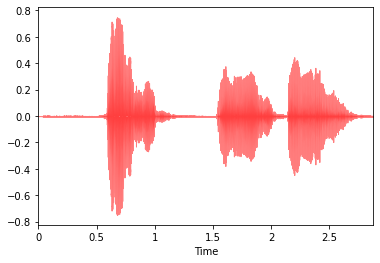

In [ ]:
import librosa
import warnings
warnings.filterwarnings('ignore')
audio_custom, sr = librosa.load("audio.mp4", sr=16000)
librosa.display.waveplot(audio_custom, sr=sr, color='r', alpha=0.5)
plt.show()

In [ ]:
sample_rate = 16000
waveform = torch.from_numpy(audio_custom.reshape(1, -1))

n_fft = 2048
win_length = None
hop_length = 400
n_mels = 256
n_mfcc = 32

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(waveform)[0]
print(mfcc.size())

torch.Size([32, 116])


In [ ]:
exp_by = 3 # on each side
sz = feat.size()[0]
feat_new = torch.zeros((sz*(exp_by*2+1), mfcc.size()[1]+2*exp_by))
for k in range(exp_by*2+1):
    feat_new[sz*k:sz*k+sz,k:mfcc.size()[1]+k] = mfcc
feat_new = feat_new[:,exp_by:-exp_by]
print(feat_new.size())

torch.Size([224, 116])


In [ ]:
feat_new = mfcc
feat_new = feat_new.to(device).T.unsqueeze(0)


In [ ]:
print(feat_new.size())
input_tensor = torch.zeros((1, 256, 32))
input_tensor[:,140:,:] = feat_new
output_logits = model_bilstm_small(input_tensor.to(device))

torch.Size([1, 116, 32])


In [ ]:
print(output_logits)

tensor([[[ 3.0858, -2.7091],
         [ 2.8129, -2.4324],
         [ 2.7475, -2.4112],
         [ 2.7893, -2.4679],
         [ 2.8425, -2.5173],
         [ 2.8768, -2.5480],
         [ 2.8996, -2.5700],
         [ 2.9178, -2.5886],
         [ 2.9347, -2.6060],
         [ 2.9514, -2.6228],
         [ 2.9681, -2.6395],
         [ 2.9849, -2.6559],
         [ 3.0014, -2.6720],
         [ 3.0176, -2.6875],
         [ 3.0335, -2.7025],
         [ 3.0494, -2.7169],
         [ 3.0658, -2.7309],
         [ 3.0829, -2.7444],
         [ 3.1005, -2.7571],
         [ 3.1173, -2.7687],
         [ 3.1322, -2.7793],
         [ 3.1448, -2.7891],
         [ 3.1557, -2.7982],
         [ 3.1653, -2.8066],
         [ 3.1738, -2.8140],
         [ 3.1813, -2.8205],
         [ 3.1879, -2.8261],
         [ 3.1939, -2.8310],
         [ 3.1993, -2.8353],
         [ 3.2044, -2.8393],
         [ 3.2095, -2.8433],
         [ 3.2149, -2.8475],
         [ 3.2208, -2.8522],
         [ 3.2276, -2.8576],
         [ 3.2

# Train with DPCL
- Including Deep Clustering Loss in the loss equation

In [ ]:
beta_1 = 0.9
beta_2 = 0.999
lr = 1e-2
num_epochs = 5
speaker_cnt = 2
seq_len = 256
epochs_done = 0
mu = 0.001

model_bilstm_dpcl = BiLSTMDiarization_DPCL(2, 32*7, 64, 2, 4, 256)
optim_dpcl = torch.optim.Adam(model_bilstm_dpcl.parameters(), lr=lr, betas=(beta_1, beta_2))
criterion = nn.BCEWithLogitsLoss()

In [ ]:
from tqdm.auto import tqdm
import sklearn
num_epochs = 5

model_bilstm_dpcl.to(device)

for epoch in range(epochs_done, epochs_done + num_epochs):
    cnt = 0
    loss_ep = 0
    for audio, label in tqdm(diarizationLoader_train, colour="blue"):
        model_bilstm_dpcl.train()
        audio = audio.to(device)
        label = label.to(device)
        batch_size = len(audio)

        dpcl_out, output = model_bilstm_dpcl(audio)
        loss_total = 0
        loss_dpcl = 0
        for count in range(batch_size):
            min_loss, min_loss_label = pit(output[count], label[count].float())
            loss = criterion(output[count], min_loss_label)
            min_loss_label.to(device)
            dpcl_out.to(device)
            dpcl_indiv = deep_clustering_loss(dpcl_out[count], min_loss_label)
            loss_total += loss + mu*dpcl_indiv
            loss_dpcl += dpcl_indiv.item()
        optim_dpcl.zero_grad()
        loss_total.backward()
        optim_dpcl.step()
        loss_ep += loss_total.item()
        cnt += 1
        if cnt%100 == 0:
            print(f"Epoch {epoch}, Iteration {cnt}: {loss_ep/cnt}")
            print(f"DPCL contribution: {loss_dpcl/loss_total.item()}")

        if cnt%200 == 0:
            model_bilstm_dpcl.eval()
            correct = 0
            total = 0
            f1_score = 0
            predictions = []
            labels = []

            for audio, label in tqdm(diarizationLoader_val, colour="red"):
                audio = audio.to(device)
                label = label.to(device)
                batch_size = len(audio)
                _, output = model_bilstm_dpcl(audio)
                loss_total_val = 0
                for count in range(batch_size):
                    min_loss, min_loss_label = pit(output[count], label[count].float())
                    label_outputs = (output[count]>=0).int()
                    correct += torch.sum((label_outputs == min_loss_label).int()).item()
                    total += torch.sum(torch.ones_like(label_outputs)).item()
                    labels.append(min_loss_label)
                    predictions.append(label_outputs)
            print("VALIDATION")
            print(f"Accuracy - {correct/total}")
            print(torch.sum(torch.cat(labels), dim=0))
            print(torch.sum(torch.cat(predictions), dim=0))
            print(f"F1 score - {list(sklearn.metrics.f1_score(torch.cat(labels).cpu().numpy(), torch.cat(predictions).cpu().numpy(), average=None))}")
            print(f"1 -> Predictions = {torch.sum(torch.cat(predictions))}, Total = {torch.sum(torch.cat(labels))}")
    print(loss_ep/cnt)
    epochs_done += 1

  0%|          | 0/1389 [00:00<?, ?it/s]

Epoch 0, Iteration 100: 14.920932149887085
DPCL contribution: 691.6866291629052
Epoch 0, Iteration 200: 14.362062962055207
DPCL contribution: 617.9269078950776


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8708312118126272
tensor([ 18171., 111395.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.939681388158977]
1 -> Predictions = 125696, Total = 129566.0
Epoch 0, Iteration 300: 14.387841444015503
DPCL contribution: 506.89953003769614
Epoch 0, Iteration 400: 14.290223335027695
DPCL contribution: 646.2430610475345


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8696458121181263
tensor([ 18320., 111246.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9390146111706662]
1 -> Predictions = 125696, Total = 129566.0
Epoch 0, Iteration 500: 14.186386808395385
DPCL contribution: 448.8376870906547
Epoch 0, Iteration 600: 14.162195347150167
DPCL contribution: 598.266727795412


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8696617235234216
tensor([ 18318., 111248.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9390235667499495]
1 -> Predictions = 125696, Total = 129566.0
Epoch 0, Iteration 700: 14.134899866240366
DPCL contribution: 639.8716135343315
Epoch 0, Iteration 800: 14.112509102225303
DPCL contribution: 638.9347608288472


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8705925407331976
tensor([ 18201., 111365.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9395472051497293]
1 -> Predictions = 125696, Total = 129566.0
Epoch 0, Iteration 900: 14.038624850379096
DPCL contribution: 338.8424778034968
Epoch 0, Iteration 1000: 14.014096250534058
DPCL contribution: 360.38091108241844


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8695423879837068
tensor([ 18333., 111233.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9389563962199647]
1 -> Predictions = 125696, Total = 129566.0
Epoch 0, Iteration 1100: 13.991684539534829
DPCL contribution: 709.7055627441575
Epoch 0, Iteration 1200: 14.023461056550344
DPCL contribution: 426.7590203052318


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8707834775967414
tensor([ 18177., 111389.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9396545542737837]
1 -> Predictions = 125696, Total = 129566.0
Epoch 0, Iteration 1300: 14.024889556444608
DPCL contribution: 455.3868933203598
14.04968975978931


  0%|          | 0/1389 [00:00<?, ?it/s]

Epoch 1, Iteration 100: 13.58357126712799
DPCL contribution: 656.4592879108696
Epoch 1, Iteration 200: 13.936557068824769
DPCL contribution: 767.1962929149877


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8705766293279023
tensor([ 18203., 111363.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9395382584082445]
1 -> Predictions = 125696, Total = 129566.0
Epoch 1, Iteration 300: 13.819517801602682
DPCL contribution: 364.64280825869145
Epoch 1, Iteration 400: 13.713824391365051
DPCL contribution: 414.91979346201333


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8704970723014257
tensor([ 18213., 111353.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9394935224362896]
1 -> Predictions = 125696, Total = 129566.0
Epoch 1, Iteration 500: 13.776261476516723
DPCL contribution: 422.913903296528
Epoch 1, Iteration 600: 13.732426311175029
DPCL contribution: 715.6742638472435


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8708630346232179
tensor([ 18167., 111399.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9396992766612539]
1 -> Predictions = 125696, Total = 129566.0
Epoch 1, Iteration 700: 13.792536532538278
DPCL contribution: 685.4248059465398
Epoch 1, Iteration 800: 13.77894221007824
DPCL contribution: 463.64912445848773


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8705448065173116
tensor([ 18207., 111359.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9395203644723799]
1 -> Predictions = 125696, Total = 129566.0
Epoch 1, Iteration 900: 13.79719719780816
DPCL contribution: 413.4966676531587
Epoch 1, Iteration 1000: 13.842352381706238
DPCL contribution: 459.1726538270338


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8704970723014257
tensor([ 18213., 111353.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9394935224362896]
1 -> Predictions = 125696, Total = 129566.0
Epoch 1, Iteration 1100: 13.8853754641793
DPCL contribution: 407.28083070298
Epoch 1, Iteration 1200: 13.892663603623708
DPCL contribution: 572.0651905903062


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8703856924643585
tensor([ 18227., 111339.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9394308857341742]
1 -> Predictions = 125696, Total = 129566.0
Epoch 1, Iteration 1300: 13.89061163865603
DPCL contribution: 663.8993882582921
13.945259455384926


  0%|          | 0/1389 [00:00<?, ?it/s]

Epoch 2, Iteration 100: 13.729766120910645
DPCL contribution: 675.6439671711721
Epoch 2, Iteration 200: 13.449339776039123
DPCL contribution: 663.820465750421


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8708630346232179
tensor([ 18167., 111399.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9396992766612539]
1 -> Predictions = 125696, Total = 129566.0
Epoch 2, Iteration 300: 13.624768737157186
DPCL contribution: 575.2189553479672
Epoch 2, Iteration 400: 13.628924043178559
DPCL contribution: 658.4001400509698


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.869956084521385
tensor([ 18281., 111285.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9391892177009972]
1 -> Predictions = 125696, Total = 129566.0
Epoch 2, Iteration 500: 13.758700424194336
DPCL contribution: 416.6375885397902
Epoch 2, Iteration 600: 13.79688994248708
DPCL contribution: 380.13938954939493


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8700356415478615
tensor([ 18271., 111295.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9392339793494268]
1 -> Predictions = 125696, Total = 129566.0
Epoch 2, Iteration 700: 13.879615267344883
DPCL contribution: 488.4222142416725
Epoch 2, Iteration 800: 13.834329175949097
DPCL contribution: 450.1980080683953


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8705448065173116
tensor([ 18207., 111359.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9395203644723799]
1 -> Predictions = 125696, Total = 129566.0
Epoch 2, Iteration 900: 13.788787203364903
DPCL contribution: 385.81830921389496
Epoch 2, Iteration 1000: 13.840318968772888
DPCL contribution: 645.6508658643354


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8708232561099797
tensor([ 18172., 111394.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9396769159390949]
1 -> Predictions = 125696, Total = 129566.0
Epoch 2, Iteration 1100: 13.88706952008334
DPCL contribution: 685.2208949446053
Epoch 2, Iteration 1200: 13.852592044274012
DPCL contribution: 451.7174968163933


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8707834775967414
tensor([ 18177., 111389.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9396545542737837]
1 -> Predictions = 125696, Total = 129566.0
Epoch 2, Iteration 1300: 13.85293640943674
DPCL contribution: 630.5091469784999
13.835461385135087


  0%|          | 0/1389 [00:00<?, ?it/s]

Epoch 3, Iteration 100: 13.944020910263061
DPCL contribution: 677.3071703603867
Epoch 3, Iteration 200: 13.544401774406433
DPCL contribution: 375.10124109926033


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8698287932790224
tensor([ 18297., 111269.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9391175912054522]
1 -> Predictions = 125696, Total = 129566.0
Epoch 3, Iteration 300: 13.788250336647033
DPCL contribution: 609.1864161505366
Epoch 3, Iteration 400: 13.669268114566803
DPCL contribution: 372.339754240088


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8681024058044806
tensor([ 18514., 111052.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9381452008042307]
1 -> Predictions = 125696, Total = 129566.0
Epoch 3, Iteration 500: 13.9127120885849
DPCL contribution: 329.5815004601511
Epoch 3, Iteration 600: 13.937322487036386
DPCL contribution: 397.62700766134475


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8703220468431772
tensor([ 18235., 111331.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9393950900108425]
1 -> Predictions = 125696, Total = 129566.0
Epoch 3, Iteration 700: 13.981876277242389
DPCL contribution: 689.3621991974032
Epoch 3, Iteration 800: 13.930813338160515
DPCL contribution: 612.0800493734076


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8708550789205702
tensor([ 18168., 111398.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9396948045922713]
1 -> Predictions = 125696, Total = 129566.0
Epoch 3, Iteration 900: 13.974068693055047
DPCL contribution: 462.3035700869353
Epoch 3, Iteration 1000: 14.001777566432953
DPCL contribution: 382.24892184076447


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8708550789205702
tensor([ 18168., 111398.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9396948045922713]
1 -> Predictions = 125696, Total = 129566.0
Epoch 3, Iteration 1100: 14.00425624327226
DPCL contribution: 433.3769864481636
Epoch 3, Iteration 1200: 14.035622192621231
DPCL contribution: 455.59833891511823


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8708630346232179
tensor([ 18167., 111399.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9396992766612539]
1 -> Predictions = 125696, Total = 129566.0
Epoch 3, Iteration 1300: 14.041649884444016
DPCL contribution: 389.3390546797353
14.051358967225616


  0%|          | 0/1389 [00:00<?, ?it/s]

Epoch 4, Iteration 100: 14.38873966217041
DPCL contribution: 601.3323441881686
Epoch 4, Iteration 200: 14.888111708164216
DPCL contribution: 635.5613560363399


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8708630346232179
tensor([ 18167., 111399.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9396992766612539]
1 -> Predictions = 125696, Total = 129566.0
Epoch 4, Iteration 300: 14.754098601341248
DPCL contribution: 642.2716596442451
Epoch 4, Iteration 400: 14.5880714571476
DPCL contribution: 666.9222917612299


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8708630346232179
tensor([ 18167., 111399.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9396992766612539]
1 -> Predictions = 125696, Total = 129566.0
Epoch 4, Iteration 500: 14.457239389419556
DPCL contribution: 429.6555540583354
Epoch 4, Iteration 600: 14.366481875578563
DPCL contribution: 446.03913917005553


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8708630346232179
tensor([ 18167., 111399.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9396992766612539]
1 -> Predictions = 125696, Total = 129566.0
Epoch 4, Iteration 700: 14.249397330284118
DPCL contribution: 500.9885243004624
Epoch 4, Iteration 800: 14.335477681159974
DPCL contribution: 608.2405939187521


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8708630346232179
tensor([ 18167., 111399.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9396992766612539]
1 -> Predictions = 125696, Total = 129566.0
Epoch 4, Iteration 900: 14.265194164911906
DPCL contribution: 399.4835154818487
Epoch 4, Iteration 1000: 14.147780731201172
DPCL contribution: 442.16186048312034


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8708630346232179
tensor([ 18167., 111399.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9396992766612539]
1 -> Predictions = 125696, Total = 129566.0
Epoch 4, Iteration 1100: 14.221388421492144
DPCL contribution: 643.224839126475
Epoch 4, Iteration 1200: 14.19357831954956
DPCL contribution: 418.8945709872275


  0%|          | 0/31 [00:00<?, ?it/s]

VALIDATION
Accuracy - 0.8708630346232179
tensor([ 18167., 111399.], device='cuda:0')
tensor([     0, 125696], device='cuda:0')
F1 score - [0.0, 0.9396992766612539]
1 -> Predictions = 125696, Total = 129566.0
Epoch 4, Iteration 1300: 14.204189045979426
DPCL contribution: 642.6306135096796
14.210590757338412
